In [1]:
# Import necessary packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
from gerrychain.metrics import mean_median, partisan_bias, polsby_popper, efficiency_gap, partisan_gini
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
import pickle
import geopandas as gp
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union
import itertools

In [2]:
# Import necessary tools from gerrymandering_tools.py
from gerrymandering_tools import *

In [4]:
# Get the graph data from the file
utah = Graph.from_json("2012_with_buffer_graph-2020-02-18.json")

graph2 = pickle.load(open('precincts_merged_multipolygons.pkl', 'rb'))

# Define our updaters
my_updaters = {"population": updaters.Tally("POP100", alias="population"),
               "d": updaters.Tally("DEM", alias="d"),
               "r": updaters.Tally("REP", alias="r"),
               "polsby_popper": polsby_popper,
               "split_counties": SplitCounties()
              }

elections = [ Election("SEN10", {"Dem": "DEM", "Rep": "REP"})]

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

# Define our initial partition
initial_partition = GeographicPartition(graph2, "US_Distric", my_updaters)

# Get the precincts
with open("2018_precincts_with_pop_and_prorated_votes.pkl",'rb') as f:
    precincts1 = pickle.load(f)
    
precincts2 = gp.read_file("precincts_merged_multipolygons.shp")

In [11]:
precincts1.loc[1887, 'US_Distric'] = 0
utah.nodes[1887]['US_Distric'] = 0

graph = utah
gdf = precincts1
merges = []

for node in graph.nodes:
    if graph.nodes[node]['POP100'] == 0:
        neighbors = [n for n in graph[node].keys() 
                               if graph.nodes[n]['CountyID'] == graph.nodes[node]['CountyID'] 
                               and graph.nodes[n]['US_Distric'] == graph.nodes[node]['US_Distric']]
        
        # Maximizing the shared perimeter of the precincts being merged is a decent way to pick good merges
        best = neighbors[np.argmax([graph[node][n]['shared_perim'] for n in neighbors])]
        merges.append(set([node, best]))

merges

[{38, 54},
 {104, 105},
 {106, 125},
 {146, 153},
 {142, 155},
 {249, 269},
 {247, 250},
 {257, 258},
 {261, 275},
 {283, 323},
 {347, 348},
 {345, 350},
 {386, 392},
 {450, 458},
 {508, 585},
 {509, 564},
 {510, 554},
 {511, 636},
 {512, 574},
 {514, 551},
 {516, 566},
 {517, 611},
 {525, 636},
 {541, 594},
 {546, 601},
 {602, 615},
 {668, 669},
 {611, 674},
 {702, 738},
 {703, 704},
 {705, 706},
 {707, 738},
 {708, 719},
 {709, 719},
 {710, 719},
 {712, 719},
 {713, 719},
 {689, 716},
 {689, 717},
 {689, 718},
 {724, 725},
 {729, 730},
 {741, 799},
 {800, 846},
 {741, 815},
 {826, 829},
 {800, 846},
 {858, 887},
 {859, 874},
 {860, 884},
 {861, 888},
 {862, 888},
 {863, 887},
 {864, 898},
 {866, 868},
 {867, 899},
 {868, 890},
 {869, 881},
 {876, 898},
 {877, 889},
 {880, 892},
 {881, 905},
 {883, 894},
 {891, 898},
 {895, 902},
 {897, 903},
 {900, 905},
 {627, 906},
 {908, 909},
 {908, 909},
 {911, 1024},
 {912, 1052},
 {913, 930},
 {914, 1234},
 {912, 918},
 {919, 994},
 {920, 1025

In [13]:
utah.nodes[2973]['POP100']

0.0

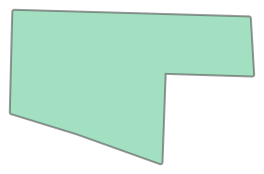

In [19]:
precincts1.iloc[2973]['geometry']